Convert and Optimize YOLOv8 with OpenVINO™

The YOLOv8 algorithm is developed by Ultralytics, is a cutting-edge, state-of-the-art (SOTA) model that builds upon the success of previous YOLO versions and introduces new features and improvements to further boost performance and flexibility. YOLOv8 is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection, image segmentation and image classification tasks.

YOLO stands for “You Only Look Once”, it is a popular family of real-time object detection algorithms. 
The original YOLO object detector was first released in 2016. Since then, different versions and variants of YOLO have been proposed, each providing a significant increase in performance and efficiency.
YOLOv7 is next stage of evalution of YOLO models family which provides a greatly improved real-time object detection accuracy without increasing the inference costs.
More details about its realization can be found in original model [repository](https://github.com/ultralytics/ultralytics)

Real-time object detection is often used as a key component in computer vision systems. 
Applications that use real-time object detection models include video analytics, robotics, autonomous vehicles, multi-object tracking and object counting, medical image analysis, and many others.


This tutorial demonstrates step-by-step instructions on how to run and optimize PyTorch\* Yolo V8 with OpenVINO.

The tutorial consists of the following steps:
- Prepare PyTorch model
- Download and prepare dataset
- Validate original model
- Convert PyTorch model to OpenVINO IR
- Validate converted model
- Prepare and run optimization pipeline
- Compare accuracy of the FP32 and quantized models.
- Compare performance of the FP32 and quantized models.

## Get Pytorch model

Generally, PyTorch models represent an instance of the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class, initialized by a state dictionary with model weights.
We will use the YOLOv8 medium model pretrained on COCO dataset, which available in this [repo](https://github.com/ultralytics/ultralytics).
Typical steps to obtain pretrained model:
1. Create instance of model class
2. Load checkpoint state dict, which contains pretrained model weights
3. Turn model to evaluation for switching some operations to inference mode

In this case, the model creators provide a API that enables converting the YOLOv8 model to ONNX and then to OpenVINO IR, so we don't need to do these steps manually.

### Prerequisites

Install necessary packages.

In [ ]:
!pip install ultralytics

In [1]:
try:
    import nncf  # noqa: F401
except ImportError:
    !pip install "git+https://github.com/openvinotoolkit/nncf.git#egg=nncf"

/home/ea/work/notebooks_env/lib/python3.8/site-packages/openvino/offline_transformations/__init__.py:10: FutureWarning: The module is private and following namespace `offline_transformations` will be removed in the future, use `openvino.runtime.passes` instead!
  warnings.warn(


INFO:nncf:NNCF initialized successfully. Supported frameworks detected: torch, tensorflow, onnx, openvino


In [2]:
from ultralytics import YOLO

model_name = "yolov8n.pt"

model = YOLO(model_name)

In [3]:
label_map = model.model.names

In [4]:
results = model("../data/image/coco_bike.jpg")

Ultralytics YOLOv8.0.3 🚀 Python-3.8.10 torch-1.13.1+cpu CPU
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /home/ea/work/openvino_notebooks/notebooks/data/image/coco_bike.jpg: 480x640 2 bicycles, 2 cars, 1 dog, 41.1ms
Speed: 0.5ms pre-process, 41.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


In [5]:
image_res = results[0]

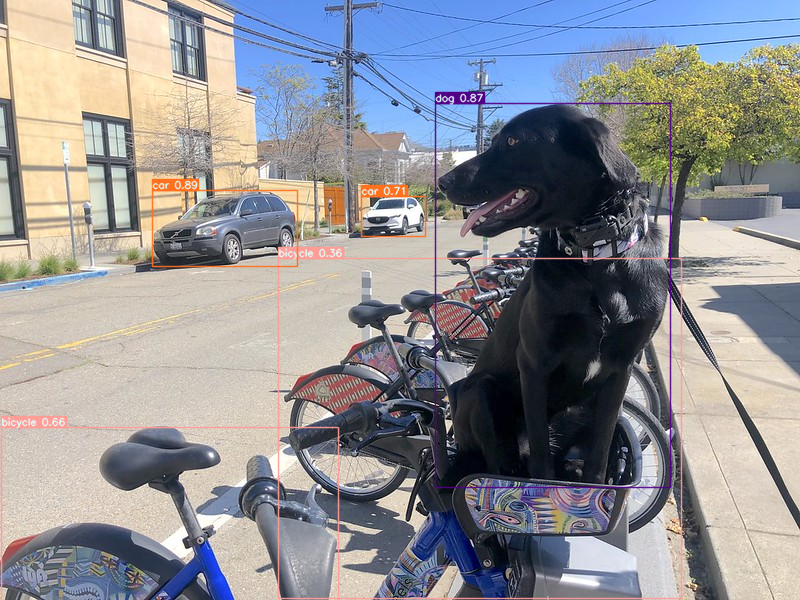

In [6]:
import cv2
import numpy as np
from PIL import Image
from ultralytics.yolo.utils.plotting import colors


def plot_one_box(x, img, color=None, label=None, line_thickness=3):
    # Plots one bounding box on image img
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  # font thickness
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)
    return img


def draw_boxes(image_res, source_image):
    for *xyxy, conf, cls in reversed(image_res.numpy()):
        label = f'{label_map[int(cls)]} {conf:.2f}'
        source_image = plot_one_box(xyxy, source_image, label=label, color=colors(int(cls)), line_thickness=1)
    return source_image


img = np.array(Image.open("../data/image/coco_bike.jpg"))
img_with_boxes = draw_boxes(image_res, img.copy())
Image.fromarray(img_with_boxes)

## Convert model to OpenVINO IR

YOLOv8 provides API for convinient model exporting to different formats including OpenVINO
`model.export` is responsible for model conversion. We need to specify format and additionally we can preserve dynamic shapes in model.

In [7]:
model.export(format="openvino", half=False, dynamic=True)

Ultralytics YOLOv8.0.3 🚀 Python-3.8.10 torch-1.13.1+cpu CPU
Fusing layers... 
YOLOv8n summary: 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from yolov8n.pt with output shape (1, 84, 8400) (6.2 MB)

ONNX: starting export with onnx 1.12.0...
ONNX: export success ✅ 0.5s, saved as yolov8n.onnx (12.2 MB)

OpenVINO: starting export with openvino 2022.3.0-9052-9752fafe8eb-releases/2022/3...
OpenVINO: export success ✅ 2.6s, saved as yolov8n_openvino_model/ (12.4 MB)

Export complete (3.2s)
Results saved to /home/ea/work/openvino_notebooks/notebooks/230-yolov8-optimization
Predict:         yolo task=detect mode=predict model=yolov8n_openvino_model/ -WARNING ⚠️ not yet supported for YOLOv8 exported models
Validate:        yolo task=detect mode=val model=yolov8n_openvino_model/ -WARNING ⚠️ not yet supported for YOLOv8 exported models
Visualize:       https://netron.app


## Verify model inference

To test model work, we create inference pipeline similar to `model.predict` method. Our pipeline consists from preprocessing step, inference of OpenVINO model and results post-processing to get bounding boxes.

In [8]:
from openvino.runtime import Core

core = Core()
ov_model = core.read_model("yolov8n_openvino_model/yolov8n.xml")
compiled_model = core.compile_model(ov_model)

### Preprocessing

Model input is tensor with shape `[-1, 3, -1, -1]` in `N, C, H, W` format, where
* `N` - number of images in batch (batch size)
* `C` - image channels
* `H` - image height
* `W` - image width

Model expects images in RGB channels format and normalized in [0, 1] range. However model support dynamic input shape with preserving input divisibility to 32, it is recommended to use static shapes e.g. 640x640 for better efficiency
To resize images to fit model size `letterbox` resize approach is used where the aspect ratio of width and height is preserved.

To keep specific shape preprocessing automatically enables padding.

In [9]:
from ultralytics.yolo.utils import ops
import torch
import numpy as np


def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)


def preprocess_image(img0: np.ndarray):
    """
    Preprocess image according to YOLOv8 input requirements. 
    Takes image in np.array format, resizes it to specific size using letterbox resize, converts color space from BGR (default in OpenCV) to RGB and changes data layout from HWC to CHW.
    
    Parameters:
      img0 (np.ndarray): image for preprocessing
    Returns:
      img (np.ndarray): image after preprocessing
      img0 (np.ndarray): original image
    """
    # resize
    img = letterbox(img0, auto=False)[0]
    
    # Convert
    img = img.transpose(2, 0, 1)
    img = np.ascontiguousarray(img)
    return img


def preprocess(image):
    input_tensor = image.astype(np.float32)  # uint8 to fp16/32
    input_tensor /= 255.0  # 0 - 255 to 0.0 - 1.0
    
    if input_tensor.ndim == 3:
        input_tensor = np.expand_dims(input_tensor, 0)
    return input_tensor

### Postprocessing

Model output contains detection boxes candidates, it is a tensor with shape `[-1,84,-1]` in format `B,84,N` where:

- `B` - batch size
- `N` - number of detection boxes

Detection box has format [`x`, `y`, `h`, `w`, `class_no_1`, ..., `class_no_80`], where:

- (`x`, `y`) - raw coordinates of box center
- `h`, `w` - raw height and width of box
- `class_no_1`, ..., `class_no_80` - probability distribution over the classes.

For getting final prediction, we need to apply non maximum supression algorithm and rescale boxes coordinates to original image size.

In [10]:
def postprocess(preds, img, orig_img, min_conf_threshold=0.25, nms_iou_threshold=0.7, agnosting_nms=False, max_detections=300):
    preds = ops.non_max_suppression(
        torch.from_numpy(preds),
        min_conf_threshold,
        nms_iou_threshold,
        agnostic=agnosting_nms,
        max_det=max_detections
    )

    for i, pred in enumerate(preds):
        shape = orig_img.shape
        pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], shape).round()

    return preds

### Test on single image

Now, when we defined preprocessing and postprocessing steps, we are ready to check model prediction

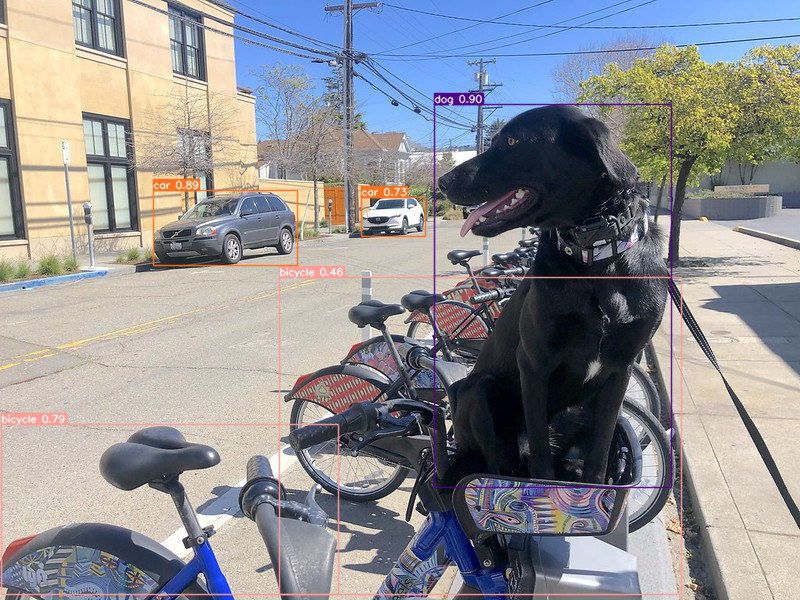

In [11]:
def detect(image, model):
    output_layer = model.output(0)
    preprocessed_image = preprocess_image(image)
    input_tensor = preprocess(preprocessed_image)
    result = model(input_tensor)[output_layer]
    detections = postprocess(result, input_tensor, image)
    return detections


input_image = np.array(Image.open("../data/image/coco_bike.jpg"))
detections = detect(input_image, compiled_model)[0]
image_with_boxes = draw_boxes(detections, input_image)

Image.fromarray(image_with_boxes)

## Check model accuracy on dataset

For comparing optimized model result with original, it is good to know some measurable results in termins of model accuracy on validation dataset. 


### Download validation dataset

YOLOv8 is pre-trained on the COCO dataset, so in order to evaluate the model accuracy we need to download it. According to the instructions provided in the YOLOv8 repo, we also need to download annotations in the format used by the model author for use with the original model evaluation scripts.


In [12]:
import sys
from zipfile import ZipFile
from pathlib import Path

sys.path.append("../utils")
from notebook_utils import download_file

DATA_URL = "http://images.cocodataset.org/zips/val2017.zip"
LABELS_URL = "https://github.com/ultralytics/yolov5/releases/download/v1.0/coco2017labels-segments.zip"

OUT_DIR = Path('./datasets')

download_file(DATA_URL, directory=OUT_DIR, show_progress=True)
download_file(LABELS_URL, directory=OUT_DIR, show_progress=True)

if not (OUT_DIR / "coco/labels").exists():
    with ZipFile(OUT_DIR / 'coco2017labels-segments.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR)
    with ZipFile(OUT_DIR / 'val2017.zip' , "r") as zip_ref:
        zip_ref.extractall(OUT_DIR / 'coco/images')

'datasets/val2017.zip' already exists.
'datasets/coco2017labels-segments.zip' already exists.


### Configure DetectionValidator helper and create DataLoader

Original model repository uses `DetectionValidator` wrapper, which represents accuracy validation pipeline. It creates dataloader and evaluation metrics and update metrics on each data batch produced by dataloader. Beside that it responsible for data preprocessing and results postprocessing. For class intialization configaration should be provided. We will use default setup, but it can be replaced with some parameters overriding to test on custom data.  

In [13]:
from ultralytics.yolo.utils import DEFAULT_CONFIG
from ultralytics.yolo.configs import get_config
args = get_config(config=DEFAULT_CONFIG)
args.data = "coco.yml"

In [14]:
validator = model.ValidatorClass(args)

In [15]:
data_loader = validator.get_dataloader("datasets/coco", 1)

val: Scanning datasets/coco/labels/val2017.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


In [16]:
from tqdm.notebook import tqdm
from ultralytics.yolo.utils.metrics import ConfusionMatrix

validator.is_coco = True
validator.class_map = ops.coco80_to_coco91_class()
validator.names = model.model.names
validator.metrics.names = validator.names
validator.nc = model.model.model[-1].nc

### Define validation function

In [28]:
def test(compiled_model, data_loader, print_stats=False):
    validator.seen = 0
    validator.jdict = []
    validator.stats = []
    validator.confusion_matrix = ConfusionMatrix(nc=validator.nc)
    output_layer = compiled_model.output(0)
    for batch_i, batch in enumerate(data_loader):
        if num_samples is not None and batch_i == num_samples:
            break
        batch = validator.preprocess(batch)
        preds = torch.from_numpy(compiled_model(batch["img"])[output_layer])
        preds = validator.postprocess(preds)
        validator.update_metrics(preds, batch)
    stats = validator.get_stats()
    if print_stats:
        print(validator.get_desc())
        validator.check_stats(stats)
        validator.print_results()
    return stats["metrics/mAP50-95(B)"]

In [18]:
compiled_model = core.compile_model(ov_model)
ap = test(compiled_model, tqdm(data_loader), print_stats=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

                   all       5000      36335      0.629      0.476      0.521       0.37


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)


`DetectionValidator.print_results` reports following list of accuracy metrics:

* `Precision` is the degree of exactness of the model in identifying only relevant objects. 
* `Recall` measures the ability of the model to detect all ground truths objects.
* `mAP@t` - mean average precision, represented as area under the Precision-Recall curve agregated over all classes in dataset,  where `t` is Intersection Over Union (IOU) threshold, degree of overlaping between ground truth and predicted objects.
            So, `mAP@.5` means that mean average precision calculated at 0.5 IOU threshold, `mAP@.5:.95` - calculated on range IOU threshlods from 0.5 to 0.95 with step 0.05.

In [19]:
compiled_model

<CompiledModel:
inputs[
<ConstOutput: names[images] shape[1,3,640,640] type: f32>
]
outputs[
<ConstOutput: names[output0] shape[1,84,8400] type: f32>
]>

## Optimize model using NNCF Post-training Quantization API

[NNCF](https://github.com/openvinotoolkit/nncf) provides a suite of advanced algorithms for Neural Networks inference optimization in OpenVINO with minimal accuracy drop.
We will use 8-bit quantization in post-training mode (without the fine-tuning pipeline) to optimize YOLOv7.

> **Note**: NNCF Post-training Quantization is available as a preview feature in OpenVINO 2022.3 release.
Fully functional support will be provided in the next releases.

The optimization process contains the following steps:

1. Create Dataset for quantization
2. Run `nncf.quantize` for getting optimized model
3. Serialize OpenVINO IR model using `openvino.runtime.serialize` function

Reuse validation dataloader in accuracy testing for quantization. 
For that, it should be wrapped into the `nncf.Dataset` object and define transformation function for getting only input tensors.

In [20]:
import nncf  # noqa: F811


def transform_fn(data_item):
    """
    Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
    Parameters:
       data_item: Tuple with data item produced by DataLoader during iteration
    Returns:
        input_tensor: Input data for quantization
    """
    input_tensor = data_item['img'].numpy()
    return input_tensor


quantization_dataset = nncf.Dataset(data_loader, transform_fn)

`nncf.quantize` function provides interface for model quantization. It requires instance of OpenVINO Model and quantization dataset. 
Optionally, some additional parameters for configuration quantization process (number of samples for quantization, preset, ignored scope etc.) can be provided.
YOLOv7 model contains non-ReLU activation functions, which require asymmetric quantization of activations. To achive better result we will use `mixed` quantization preset.
It provides symmetric quantization of weights and asymmetric quantization of activations.

In [ ]:
quantized_model = nncf.quantize_with_accuracy_control(ov_model, quantization_dataset, quantization_dataset, test, preset=nncf.QuantizationPreset.MIXED)

0
INFO:openvino.tools.pot.pipeline.pipeline:Inference Engine version:                2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Model Optimizer version:                 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.pipeline.pipeline:Post-Training Optimization Tool version: 2022.3.0-9052-9752fafe8eb-releases/2022/3
INFO:openvino.tools.pot.statistics.collector:Start computing statistics for algorithms : AccuracyAwareCommon
INFO:openvino.tools.pot.statistics.collector:Computing statistics finished
INFO:openvino.tools.pot.pipeline.pipeline:Start algorithm: AccuracyAwareCommon
INFO:openvino.tools.pot.algorithms.quantization.accuracy_aware_common.algorithm:Start original model inference
0
1
2
3
4
5
6
7
8
9
10
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [22]:
from openvino.runtime import serialize
serialize(quantized_model, 'yolov8n-int8.xml')

## Validate Quantized model inference

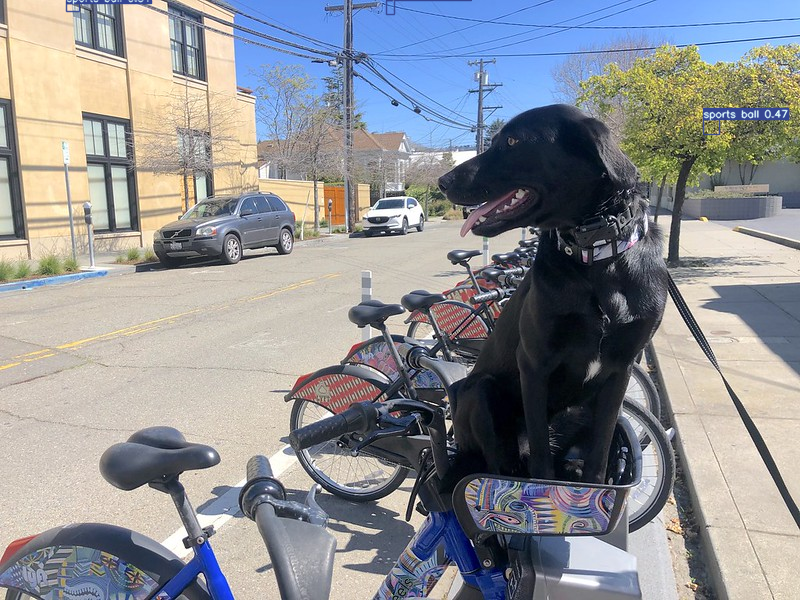

In [23]:
quantized_compiled_model = core.compile_model(quantized_model)
input_image = np.array(Image.open("../data/image/coco_bike.jpg"))
detections = detect(input_image, quantized_compiled_model)[0]
image_with_boxes = draw_boxes(detections, input_image)

Image.fromarray(image_with_boxes)

## Validate quantized model accuracy

In [24]:
compiled_model = core.compile_model(quantized_model)
ap = test(compiled_model, tqdm(data_loader), print_stats=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Compare Performance of the Original and Quantized Models
Finally, use the OpenVINO [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) to measure the inference performance of the `FP32` and `INT8` models.

> NOTE: For more accurate performance, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app -m model.xml -d CPU` to benchmark async inference on CPU for one minute. Change `CPU` to `GPU` to benchmark on GPU. Run `benchmark_app --help` to see an overview of all command-line options.

In [ ]:
# Inference FP32 model (OpenVINO IR)
!benchmark_app -m yolov8n_openvino_model/yolov8n.xml -d CPU -api async -shape "[1,3,640,640]"

In [ ]:
# Inference INT8 model (OpenVINO IR)
!benchmark_app -m yolov8n-int8.xml -d CPU -api async -shape [1,3,640,640]